In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from utils import autoparse_year
import igraph as ig

In [125]:
from scipy import stats
from scipy.stats import t

In [121]:
from typing import Callable

def bootstrap(
	x: np.ndarray,
	alpha: float = 0.95,
	n: int = 1000,
	agg: Callable[[np.ndarray], float] = np.mean
):
	"""Compute confidence interval of a given data aggregate

	Parameters
	----------
	x : np.ndarray
		data
	alpha : float, optional
		size of the confidence interval, by default 0.95
	n : int, optional
		number of resamples, by default 1_000
	agg : Callable[[np.ndarray], float], optional
		aggregation function, by default np.mean

	Returns
	-------
	low, high : tuple[float, float]
		lower and higher confidence levels
	"""

	aggs = np.zeros(n)

	for i in range(n):
		sample = x[np.random.randint(0, len(x), len(x))]  # resample data uniformly
		aggs[i] = agg(sample)

	delta = (1-alpha)/2
	return np.percentile(aggs, 100*delta), np.percentile(aggs, 100*(1-delta))

In [30]:
df_edges = pd.read_pickle('../data/generated/graph/actor_graph_full.grouped.pkl')
df_actors = pd.read_pickle('../data/generated/preprocessed/characters.pkl')

df_actors

,wiki_id,fb_movie_id,release,character_name,actor_age,fb_char_id,fb_actor_id,actor_name,actor_birth,ethnicity,actor_height,actor_gender,actor_nationality
0,975900,/m/03vyhn,2001-08-24,Akooshay,42.0,/m/0bgchxw,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America
1,24767455,/m/0809s7n,2009-10-16,Captain Diaz,51.0,/m/08d9z0b,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America
2,5337169,/m/0dg7mt,2001,NaN,42.0,/m/04htxdc,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America
3,1330220,/m/04t8wq,1990-06-22,NaN,31.0,/m/0cg7kl2,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America
4,14686017,/m/03gt21w,1990-01-12,NaN,31.0,/m/09j0r8t,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Additional Voices,38.0,/m/0kr405f,/m/0gn4bz,Sonny Byrkett,1954,NaN,NaN,M,NaN
450665,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,38.0,/m/0kr407w,/m/0gn4bz,Sonny Byrkett,1954,NaN,NaN,M,NaN
450666,913762,/m/03pcrp,1992-05-21,Silvie Gena,34.0,/m/0kr40b9,/m/0gn4nd,Susan Byrkett,1958,NaN,NaN,F,NaN
450667,913762,/m/03pcrp,1992-05-21,Exegran,NaN,/m/0kr407c,/m/0kr407h,Hal Cleaveland,NaN,NaN,NaN,M,NaN


In [31]:
df_edges

,actor1_fbid,actor2_fbid,movie_count
503641,/m/02cvp8,/m/02t0n9,219
503751,/m/02cvp8,/m/045g4l,119
655469,/m/02t0n9,/m/045g4l,119
906958,/m/03mv0b,/m/0lh0c,101
503672,/m/02cvp8,/m/030dx5,82
...,...,...,...
717944,/m/02z28y7,/m/09t0l3,1
717943,/m/02z28y7,/m/09rxk8z,1
717942,/m/02z28y7,/m/09rvxt5,1
717941,/m/02z28y7,/m/09q3gc,1


In [32]:
x=df_edges.rename(columns={"actor2_fbid": "actor1_fbid","actor1_fbid": "actor2_fbid"})
df_edges= pd.concat([df_edges, x])
df_edges

,actor1_fbid,actor2_fbid,movie_count
503641,/m/02cvp8,/m/02t0n9,219
503751,/m/02cvp8,/m/045g4l,119
655469,/m/02t0n9,/m/045g4l,119
906958,/m/03mv0b,/m/0lh0c,101
503672,/m/02cvp8,/m/030dx5,82
...,...,...,...
717944,/m/09t0l3,/m/02z28y7,1
717943,/m/09rxk8z,/m/02z28y7,1
717942,/m/09rvxt5,/m/02z28y7,1
717941,/m/09q3gc,/m/02z28y7,1


In [34]:
df_actors['year_of_birth'] = df_actors.actor_birth.apply(autoparse_year).astype('Int64')
df_actors=df_actors.rename(columns={"fb_actor_id": "actor1_fbid"})
df_actors

,wiki_id,fb_movie_id,release,character_name,actor_age,fb_char_id,actor1_fbid,actor_name,actor_birth,ethnicity,actor_height,actor_gender,actor_nationality,year_of_birth
0,975900,/m/03vyhn,2001-08-24,Akooshay,42.0,/m/0bgchxw,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
1,24767455,/m/0809s7n,2009-10-16,Captain Diaz,51.0,/m/08d9z0b,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
2,5337169,/m/0dg7mt,2001,NaN,42.0,/m/04htxdc,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
3,1330220,/m/04t8wq,1990-06-22,NaN,31.0,/m/0cg7kl2,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
4,14686017,/m/03gt21w,1990-01-12,NaN,31.0,/m/09j0r8t,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Additional Voices,38.0,/m/0kr405f,/m/0gn4bz,Sonny Byrkett,1954,NaN,NaN,M,NaN,1954
450665,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,38.0,/m/0kr407w,/m/0gn4bz,Sonny Byrkett,1954,NaN,NaN,M,NaN,1954
450666,913762,/m/03pcrp,1992-05-21,Silvie Gena,34.0,/m/0kr40b9,/m/0gn4nd,Susan Byrkett,1958,NaN,NaN,F,NaN,1958
450667,913762,/m/03pcrp,1992-05-21,Exegran,NaN,/m/0kr407c,/m/0kr407h,Hal Cleaveland,NaN,NaN,NaN,M,NaN,<NA>


In [35]:
df_actors_reduced= df_actors.drop_duplicates(subset= 'actor1_fbid')
df_actors_reduced= df_actors_reduced.drop(['wiki_id','fb_movie_id','release','character_name','fb_char_id','actor_birth'], axis=1)
df_actors_reduced

,actor_age,actor1_fbid,actor_name,ethnicity,actor_height,actor_gender,actor_nationality,year_of_birth
0,42.0,/m/03wcfv7,Wanda De Jesus,NaN,1.620,F,United States of America,1958
8,27.0,/m/0346l4,Natasha Henstridge,NaN,1.780,F,Canada,1974
31,32.0,/m/01vw26l,Ice Cube,NaN,1.727,M,United States of America,1969
64,33.0,/m/034hyc,Jason Statham,NaN,1.750,M,United Kingdom,1967
95,23.0,/m/01y9xg,Clea DuVall,NaN,1.650,F,United States of America,1977
...,...,...,...,...,...,...,...,...
450663,NaN,/m/0kr409z,Violet Bronte,NaN,NaN,F,NaN,<NA>
450664,38.0,/m/0gn4bz,Sonny Byrkett,NaN,NaN,M,NaN,1954
450666,34.0,/m/0gn4nd,Susan Byrkett,NaN,NaN,F,NaN,1958
450667,NaN,/m/0kr407h,Hal Cleaveland,NaN,NaN,M,NaN,<NA>


In [36]:
df_actors_reduced= pd.merge(df_actors_reduced, (df_actors.groupby('actor1_fbid').apply(lambda x: pd.Series({
        'number_of_movies': x['wiki_id'].count()
    }))),on='actor1_fbid')

In [37]:
df_actors_reduced

,actor_age,actor1_fbid,actor_name,ethnicity,actor_height,actor_gender,actor_nationality,year_of_birth,number_of_movies
0,42.0,/m/03wcfv7,Wanda De Jesus,NaN,1.620,F,United States of America,1958,8
1,27.0,/m/0346l4,Natasha Henstridge,NaN,1.780,F,Canada,1974,23
2,32.0,/m/01vw26l,Ice Cube,NaN,1.727,M,United States of America,1969,33
3,33.0,/m/034hyc,Jason Statham,NaN,1.750,M,United Kingdom,1967,31
4,23.0,/m/01y9xg,Clea DuVall,NaN,1.650,F,United States of America,1977,31
...,...,...,...,...,...,...,...,...,...
135755,NaN,/m/0kr409z,Violet Bronte,NaN,NaN,F,NaN,<NA>,1
135756,38.0,/m/0gn4bz,Sonny Byrkett,NaN,NaN,M,NaN,1954,2
135757,34.0,/m/0gn4nd,Susan Byrkett,NaN,NaN,F,NaN,1958,1
135758,NaN,/m/0kr407h,Hal Cleaveland,NaN,NaN,M,NaN,<NA>,1


In [38]:
x=df_edges.merge(df_actors_reduced, on='actor1_fbid')
x

,actor1_fbid,actor2_fbid,movie_count,actor_age,actor_name,ethnicity,actor_height,actor_gender,actor_nationality,year_of_birth,number_of_movies
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.62,M,United States of America,1897,225
1,/m/02cvp8,/m/045g4l,119,NaN,Moe Howard,NaN,1.62,M,United States of America,1897,225
2,/m/02cvp8,/m/030dx5,82,NaN,Moe Howard,NaN,1.62,M,United States of America,1897,225
3,/m/02cvp8,/m/09gx1x,40,NaN,Moe Howard,NaN,1.62,M,United States of America,1897,225
4,/m/02cvp8,/m/02z023s,40,NaN,Moe Howard,NaN,1.62,M,United States of America,1897,225
...,...,...,...,...,...,...,...,...,...,...,...
4160573,/m/0byfs8w,/m/0312tt,1,NaN,Herman Rottger,NaN,NaN,NaN,NaN,<NA>,1
4160574,/m/0c8nts,/m/02yy__,1,NaN,Steven Jacobs,NaN,NaN,M,Australia,1967,1
4160575,/m/0ksbf9,/m/02xn5c,1,NaN,Ann Pennington,NaN,1.47,F,United States of America,1893,1
4160576,/m/0n4dnst,/m/02xwgr,1,NaN,Mary C. McKitrick,NaN,NaN,NaN,NaN,<NA>,1


In [39]:
df_actors_reduced=df_actors_reduced.rename(columns={"actor1_fbid": "actor2_fbid"})
df_edges= x.merge(df_actors_reduced, on='actor2_fbid')

In [40]:
df_edges

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160573,/m/091997,/m/03c073,1,NaN,John C. Rice,NaN,NaN,M,United States of America,1858,1,NaN,May Irwin,NaN,NaN,F,United States of America,1862,1
4160574,/m/0gc7pfd,/m/03bkpx,1,NaN,Don Brady,NaN,NaN,M,NaN,<NA>,1,37.0,Robert Hughes,NaN,NaN,M,NaN,1938,1
4160575,/m/09n13f,/m/03c757g,1,32.0,Dick Wagner,NaN,NaN,M,NaN,1943,1,27.0,Steve Hunter,NaN,NaN,M,NaN,1948,1
4160576,/m/0lsz,/m/03c5y,1,52.0,Anatoly Karpov,NaN,NaN,M,NaN,1951,1,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1


In [102]:
df_edges_age=df_edges.dropna(subset=['actor_age_x'])
df_edges_age=df_edges_age.dropna(subset=['actor_age_y'])

#df_edges_red=df_edges_red.dropna(subset=['actor_height_x'])
#df_edges_red=df_edges_red.dropna(subset=['actor_height_y'])
df_edges_gender=df_edges.dropna(subset=['actor_gender_x'])
df_edges_gender=df_edges_gender.dropna(subset=['actor_gender_y'])

df_edges_nat=df_edges.dropna(subset=['actor_nationality_x'])
df_edges_nat=df_edges_nat.dropna(subset=['actor_nationality_y'])

df_edges_birth=df_edges.dropna(subset=['year_of_birth_x'])
df_edges_birth=df_edges_birth.dropna(subset=['year_of_birth_y'])
df_edges_birth=df_edges_birth[df_edges_birth['year_of_birth_x']>1800]



print(len(df_edges_age),len(df_edges_gender),len(df_edges_nat),len(df_edges_birth))

1875556 96597 2368072 2383670


In [43]:
homophily = {}

In [44]:
df_edges_birth['same_age'] = df_edges_birth.apply(lambda x: 1 if (abs(x.year_of_birth_x-x.year_of_birth_y) < 5) else (-1), axis= 1)
df_edges_birth

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_age
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.6200,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.6510,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160570,/m/03wcshk,/m/03436f,1,42.0,Gianni Raimondi,NaN,NaN,M,NaN,1923,1,30.0,Mirella Freni,NaN,NaN,F,NaN,1935,1,-1
4160571,/m/0g1pw2,/m/0377_8,1,NaN,Billy Herrington,NaN,1.8542,M,United States of America,1969,1,NaN,Ron Athey,NaN,NaN,M,NaN,1961,1,-1
4160573,/m/091997,/m/03c073,1,NaN,John C. Rice,NaN,NaN,M,United States of America,1858,1,NaN,May Irwin,NaN,NaN,F,United States of America,1862,1,1
4160575,/m/09n13f,/m/03c757g,1,32.0,Dick Wagner,NaN,NaN,M,NaN,1943,1,27.0,Steve Hunter,NaN,NaN,M,NaN,1948,1,-1


In [45]:
age_homophily = df_edges_birth.groupby('actor1_fbid')['same_age'].agg(['mean'])
print('mean =',age_homophily.mean(), 'and std =', age_homophily.std())
homophily['age']= {
		'mean': float(age_homophily.mean()),
		'std': float(age_homophily.std())
	}

mean = mean   -0.535918
dtype: float64 and std = mean    0.367928
dtype: float64


In [122]:
bootstrap(age_homophily.to_numpy())

(-0.5390908792020492, -0.5328677684125696)

In [46]:
edges_height=df_edges.dropna(subset=['actor_height_x'])
edges_height= edges_height.dropna(subset=['actor_height_y'])
edges_height=edges_height[df_edges['actor_height_x']<3]
edges_height['same_height'] = edges_height.apply(lambda x: 1 if (abs(x.actor_height_x-x.actor_height_y) < 0.05) else (-1), axis= 1)
edges_height

/var/folders/ds/cj908hnj5zq16fhjrglmxkrw0000gn/T/ipykernel_3110/609604864.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  edges_height=edges_height[df_edges['actor_height_x']<3]


,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_height
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
8,/m/02z475f,/m/02t0n9,24,NaN,Al Thompson,NaN,1.700,M,United States of America,1884,25,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
17,/m/03mdp_b,/m/02t0n9,11,NaN,Lynton Brent,NaN,1.770,M,United States of America,1897,21,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
20,/m/03cv7x1,/m/02t0n9,13,35.0,Dick Curtis,NaN,1.900,M,United States of America,1902,21,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160317,/m/076wpzj,/m/02pj1mn,1,20.0,Lemon Hanazawa,Japanese people,1.590,F,NaN,1984,5,34.0,Maki Tomoda,Japanese people,1.6400,F,NaN,1972,2,1
4160341,/m/06g_vy,/m/056wrw2,1,36.0,Stephanie Swift,French Americans,1.550,F,United States of America,1972,2,28.0,Ariel X,NaN,1.6000,F,NaN,1980,1,-1
4160343,/m/0bh93c1,/m/058f6y0,1,NaN,Jade Starr,NaN,1.650,F,United States of America,1981,1,NaN,Jayme Langford,NaN,1.6000,F,United States of America,1987,1,1
4160507,/m/02r672s,/m/026jg50,1,36.0,Zeb Atlas,NaN,1.905,M,United States of America,1970,1,26.0,Mark Dalton,NaN,1.7780,M,United States of America,1980,1,-1


In [47]:
height_homophily = edges_height.groupby('actor1_fbid')['same_height'].agg(['mean'])
print('mean =',height_homophily.mean(), 'and std =', height_homophily.std())
homophily['height']= {
		'mean': float(height_homophily.mean()),
		'std': float(height_homophily.std())
	}

mean = mean   -0.497402
dtype: float64 and std = mean    0.336967
dtype: float64


In [119]:
bootstrap(height_homophily.to_numpy())

(-0.503942559644448, -0.49173782689288875)

In [48]:
df_edges_gender['same_gender'] = df_edges_gender.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
df_edges_gender

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_gender
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.6200,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.6510,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160571,/m/0g1pw2,/m/0377_8,1,NaN,Billy Herrington,NaN,1.8542,M,United States of America,1969,1,NaN,Ron Athey,NaN,NaN,M,NaN,1961,1,1
4160573,/m/091997,/m/03c073,1,NaN,John C. Rice,NaN,NaN,M,United States of America,1858,1,NaN,May Irwin,NaN,NaN,F,United States of America,1862,1,-1
4160574,/m/0gc7pfd,/m/03bkpx,1,NaN,Don Brady,NaN,NaN,M,NaN,<NA>,1,37.0,Robert Hughes,NaN,NaN,M,NaN,1938,1,1
4160575,/m/09n13f,/m/03c757g,1,32.0,Dick Wagner,NaN,NaN,M,NaN,1943,1,27.0,Steve Hunter,NaN,NaN,M,NaN,1948,1,1


In [49]:
gender_homophily = df_edges_gender.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print('mean =',gender_homophily.mean(), 'and std =', gender_homophily.std())
homophily['gender']= {
		'mean': float(gender_homophily.mean()),
		'std': float(gender_homophily.std())
	}

mean = mean    0.117427
dtype: float64 and std = mean    0.450507
dtype: float64


In [124]:
m = gender_homophily.mean() 
s = gender_homophily.std() 
dof = len(gender_homophily)-1 
confidence = 0.95
t_crit = np.abs(t.ppf((1-confidence)/2,dof))
(m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x))) 

(mean    0.11375
 dtype: float64,
 mean    0.121104
 dtype: float64)

In [120]:
bootstrap(gender_homophily.to_numpy())

(0.11473289628311803, 0.12016101100008678)

> check value for male actor and female actress indenpendantly

In [50]:
edges_gender_m = df_edges[df_edges['actor_gender_x'] == 'M']
edges_gender_m= edges_gender_m.dropna(subset=['actor_gender_y'])
edges_gender_m['same_gender'] = edges_gender_m.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
edges_gender_m

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_gender
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.6200,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.6510,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160571,/m/0g1pw2,/m/0377_8,1,NaN,Billy Herrington,NaN,1.8542,M,United States of America,1969,1,NaN,Ron Athey,NaN,NaN,M,NaN,1961,1,1
4160573,/m/091997,/m/03c073,1,NaN,John C. Rice,NaN,NaN,M,United States of America,1858,1,NaN,May Irwin,NaN,NaN,F,United States of America,1862,1,-1
4160574,/m/0gc7pfd,/m/03bkpx,1,NaN,Don Brady,NaN,NaN,M,NaN,<NA>,1,37.0,Robert Hughes,NaN,NaN,M,NaN,1938,1,1
4160575,/m/09n13f,/m/03c757g,1,32.0,Dick Wagner,NaN,NaN,M,NaN,1943,1,27.0,Steve Hunter,NaN,NaN,M,NaN,1948,1,1


In [51]:
gender_homophily_m = edges_gender_m.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print(gender_homophily_m.mean(), gender_homophily_m.std())
homophily['gender_m']= {
		'mean': float(gender_homophily_m.mean()),
		'std': float(gender_homophily_m.std())
	}

mean    0.354056
dtype: float64 mean    0.321134
dtype: float64


In [52]:
edges_gender_f = df_edges[df_edges['actor_gender_x'] == 'F']
edges_gender_f= edges_gender_f.dropna(subset=['actor_gender_y'])
edges_gender_f['same_gender'] = edges_gender_f.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
edges_gender_f

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_gender
10,/m/02zbgr_,/m/02t0n9,19,NaN,Symona Boniface,NaN,NaN,F,United States of America,1894,23,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
28,/m/03gxzbc,/m/02t0n9,11,37.0,Harriette Tarler,NaN,NaN,F,United States of America,1920,12,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
35,/m/03ng17,/m/02t0n9,1,21.0,Anita Garvin,NaN,1.68,F,United States of America,1907,10,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
38,/m/026fz4v,/m/02t0n9,7,28.0,Bonnie Bonnell,NaN,NaN,F,NaN,1905,7,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
39,/m/03hn40x,/m/02t0n9,7,36.0,Dorothy Appleby,NaN,NaN,F,United States of America,1906,9,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160540,/m/01p7r_x,/m/01lyqgd,1,43.0,Buffy Sainte-Marie,indigenous peoples of the Americas,NaN,F,Canada,1941,1,37.0,Laura Nyro,NaN,NaN,F,NaN,1947,1,1
4160545,/m/0d8zt_,/m/03l2_8,1,35.0,Sabriye Tenberken,NaN,NaN,F,NaN,1970,1,37.0,Erik Weihenmayer,NaN,NaN,M,NaN,1968,1,-1
4160546,/m/03s3_q,/m/03mspj,1,NaN,Saira Shah,NaN,NaN,F,NaN,1964,1,NaN,James Miller,NaN,NaN,M,NaN,1968,1,-1
4160554,/m/0f54tyd,/m/04_7c_8,1,27.0,Jennifer Rainsford,NaN,NaN,F,NaN,1982,1,NaN,Tora Martens,NaN,NaN,M,NaN,<NA>,1,-1


In [53]:
gender_homophily_f = edges_gender_f.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print('mean =',gender_homophily_f.mean(), 'and std =', gender_homophily_f.std())
homophily['gender_f']= {
		'mean': float(gender_homophily_f.mean()),
		'std': float(gender_homophily_f.std())
	}

mean = mean   -0.287634
dtype: float64 and std = mean    0.337522
dtype: float64


In [54]:
df_edges_nat['same_country'] = df_edges_nat.apply(lambda x: 1 if (x.actor_nationality_x == x.actor_nationality_y) else (-1), axis= 1)
df_edges_nat

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_country
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160564,/m/0cr4_w,/m/02rztwp,1,NaN,Tim Key,NaN,NaN,M,United Kingdom,1976,1,NaN,Tom Basden,NaN,NaN,M,United Kingdom,1980,1,1
4160566,/m/03hhxxm,/m/02prqqw,1,NaN,Jeanne Delvair,NaN,NaN,F,France,1877,1,NaN,Paul Mounet,NaN,NaN,M,France,1847,1,1
4160569,/m/0g8nhwk,/m/02pxpmk,1,28.0,Gregor Torzs,NaN,NaN,M,Germany,1970,1,24.0,Miriam Lahnstein,NaN,NaN,F,Germany,1974,1,1
4160573,/m/091997,/m/03c073,1,NaN,John C. Rice,NaN,NaN,M,United States of America,1858,1,NaN,May Irwin,NaN,NaN,F,United States of America,1862,1,1


In [55]:
country_homophily = df_edges_nat.groupby('actor1_fbid')['same_country'].agg(['mean'])
print('mean =',country_homophily.mean(), 'and std =', country_homophily.std())
homophily['country']= {
		'mean': float(country_homophily.mean()),
		'std': float(country_homophily.std())
	}

mean = mean    0.460245
dtype: float64 and std = mean    0.610893
dtype: float64


In [56]:
edges_nbr_movies=df_edges.dropna(subset=['number_of_movies_x'])
edges_nbr_movies= edges_nbr_movies.dropna(subset=['number_of_movies_y'])
edges_nbr_movies['same_country'] = edges_nbr_movies.apply(lambda x: 1 if (abs(x.number_of_movies_x -x.number_of_movies_y) < 3) else (-1), axis= 1)
edges_nbr_movies

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_country
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160573,/m/091997,/m/03c073,1,NaN,John C. Rice,NaN,NaN,M,United States of America,1858,1,NaN,May Irwin,NaN,NaN,F,United States of America,1862,1,1
4160574,/m/0gc7pfd,/m/03bkpx,1,NaN,Don Brady,NaN,NaN,M,NaN,<NA>,1,37.0,Robert Hughes,NaN,NaN,M,NaN,1938,1,1
4160575,/m/09n13f,/m/03c757g,1,32.0,Dick Wagner,NaN,NaN,M,NaN,1943,1,27.0,Steve Hunter,NaN,NaN,M,NaN,1948,1,1
4160576,/m/0lsz,/m/03c5y,1,52.0,Anatoly Karpov,NaN,NaN,M,NaN,1951,1,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1


In [57]:
nbr_movies_homophily = edges_nbr_movies.groupby('actor1_fbid')['same_country'].agg(['mean'])
print('mean =',nbr_movies_homophily.mean(), 'and std =', nbr_movies_homophily.std())
homophily['nbr_of_movies']= {
		'mean': float(nbr_movies_homophily.mean()),
		'std': float(nbr_movies_homophily.std())
	}


mean = mean    0.062217
dtype: float64 and std = mean    0.628386
dtype: float64


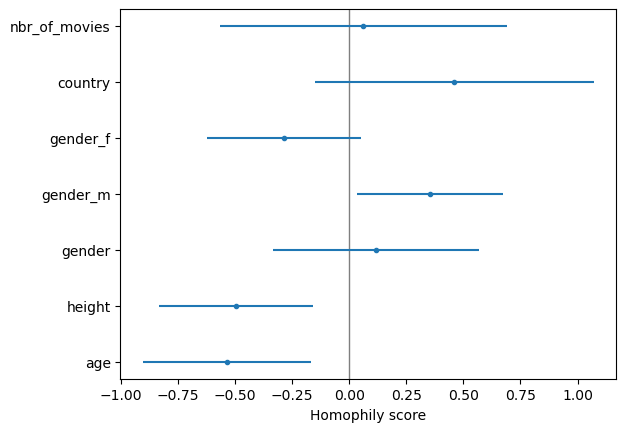

In [58]:
fig, ax = plt.subplots()

ax.axvline(0, color='tab:gray', linewidth=1)
ax.errorbar(
	x=[ a['mean'] for a in homophily.values() ], y=range(len(homophily)),
	xerr=np.array([(a['std']) for a in homophily.values()]).T,
	linestyle='', marker='.'
)
ax.set_yticks(range(len(homophily)))
ax.set_yticklabels([ key for key, values in homophily.items() ])
plt.xlabel("Homophily score")

plt.show()

In [59]:
import seaborn as sns

In [66]:
# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m
df

,x,g
0,64.038123,A
1,66.147050,B
2,66.370011,C
3,68.791019,D
4,70.583534,E
...,...,...
495,69.358022,F
496,72.212877,G
497,70.474247,H
498,73.251022,I


In [86]:
df_visu = pd.DataFrame({'values':age_homophily['mean']})
df_visu= pd.concat([df_visu, pd.DataFrame({'values':height_homophily['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_m['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_f['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':country_homophily['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':nbr_movies_homophily['mean']})])
df_visu


,values
actor1_fbid,
/m/010p3,-0.431579
/m/010q36,-0.866667
/m/010wx,-1.000000
/m/010xjr,-0.633588
/m/0112yl,-0.587156
...,...
/m/0z58,0.666667
/m/0z9q0,0.000000
/m/0zcb7,-0.739130


In [89]:
range_idx = [len(age_homophily),len(height_homophily),len(gender_homophily),len(gender_homophily_m),len(gender_homophily_f),len(country_homophily),len(nbr_movies_homophily)]
name = ['age','height','gender','gender_m','gender_f','country','nbr_movies']
idx= []
for i, name in zip(range_idx, name):
    for j in range(i):
        idx.append(name)

'nbr_movies'

In [93]:
df_visu['name']= idx
df_visu= df_visu.reset_index(drop=True)
df_visu

,values,name
0,-0.431579,age
1,-0.866667,age
2,-1.000000,age
3,-0.633588,age
4,-0.587156,age
...,...,...
453315,0.666667,nbr_movies
453316,0.000000,nbr_movies
453317,-0.739130,nbr_movies
453318,-0.968661,nbr_movies


/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/s

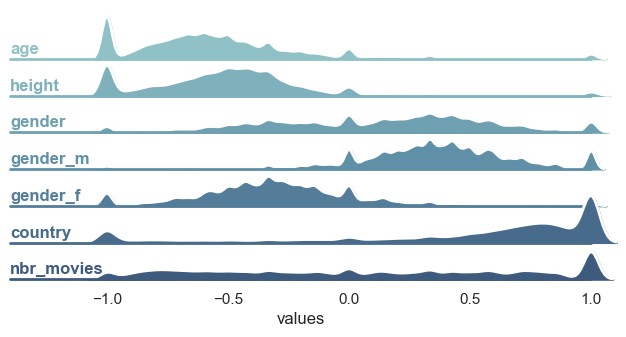

In [98]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_visu, row="name", hue="name", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "values")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(-1.4, 1))



In [130]:
df_gender_reduced = df_edges_gender.drop_duplicates(subset= 'actor1_fbid')
nbr_of_men = len(df_gender_reduced[df_gender_reduced['actor_gender_x'] == 'M'])
nbr_of_women = len(df_gender_reduced) - nbr_of_men
hypothetical_gender_homophily_score = (nbr_of_men*((nbr_of_men-1)+ (-1)*nbr_of_women))/(len(df_gender_reduced)-1) + (nbr_of_women*((nbr_of_women-1)+ (-1)*nbr_of_men))/(len(df_gender_reduced)-1)
hypothetical_gender_homophily= hypothetical_gender_homophily_score/len(df_gender_reduced)
hypothetical_gender_homophily


0.06888730381288774

In [151]:
df_edges_nat_reduced = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')
xy = df_edges_nat_reduced.groupby('actor_nationality_x')['actor1_fbid'].agg(['count'])
total_actor= xy.sum()
homophily_score=0
for i in xy.iloc:
    homophily_score+= (int(i)*(int(i)-1)+(-1)*(total_actor-int(i)))/(total_actor-1)
hypo_homophily_country = homophily_score/total_actor
hypo_homophily_country

count    0.161674
dtype: float64

In [276]:
edges_country=df_edges.dropna(subset=['actor_nationality_x'])
edges_country= edges_country.dropna(subset=['actor_nationality_y'])
edges_country= edges_country.dropna(subset=['year_of_birth_x'])
homophily_country = {}

for i in range(13):
    country_per_decade = edges_country[edges_country['year_of_birth_x'] > (1900+i*10)]
    country_per_decade = country_per_decade[country_per_decade['year_of_birth_x'] < (1910+i*10)]
    country_per_decade['same_country'] = country_per_decade.apply(lambda x: 1 if (x.actor_nationality_x == x.actor_nationality_y) else (-1), axis= 1)
    country_homophily = country_per_decade.groupby('actor1_fbid')['same_country'].agg(['mean'])
    homophily_country['decade'+str(i)]= {
		'mean': float(country_homophily.mean()),
		'std': float(country_homophily.std())
	}

In [283]:
del homophily_country["decade11"]
del homophily_country["decade12"]

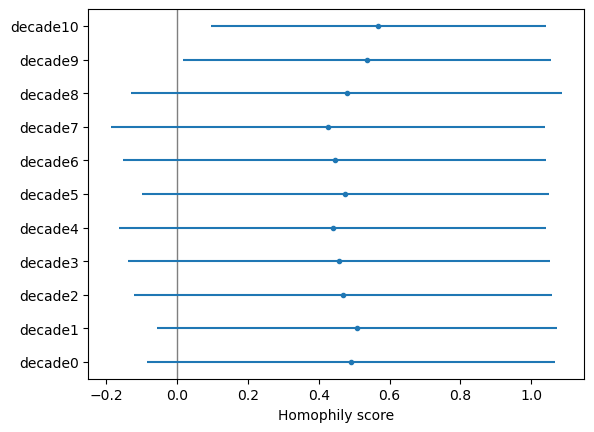

In [285]:
fig, ax = plt.subplots()

ax.axvline(0, color='tab:gray', linewidth=1)
ax.errorbar(
	x=[ a['mean'] for a in homophily_country.values() ], y=range(len(homophily_country)),
	xerr=np.array([(a['std']) for a in homophily_country.values()]).T,
	linestyle='', marker='.'
)
ax.set_yticks(range(len(homophily_country)))
ax.set_yticklabels([ key for key, values in homophily_country.items() ])
plt.xlabel("Homophily score")

plt.show()

In [41]:
import networkx as nx

In [116]:
df_edges_nat.drop_duplicates(subset= 'actor1_fbid').groupby('actor_nationality_x')['actor_nationality_x'].agg(['count']).sort_values(by='count', ascending= False).head(10)

,count
actor_nationality_x,
United States of America,6796
United Kingdom,1412
Canada,515
India,384
Japan,230
Australia,204
South Korea,178
Germany,138
France,137


In [84]:
df_edges_grouped= df_edges_red[['actor1_fbid','actor2_fbid','movie_count']]
g = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
print(g)

Graph with 36117 nodes and 800828 edges


In [85]:
x = edges_gender.drop_duplicates(subset= 'actor1_fbid')
class_attr = dict(zip(x['actor1_fbid'], 
x['actor_gender_x']))
nx.set_node_attributes(g, name = "actor_gender_x", 
values = class_attr)

In [86]:
nx.attribute_assortativity_coefficient(g, "actor_gender_x")

0.016975559634246747

In [87]:
df_edges_grouped= df_edges_red[['actor1_fbid','actor2_fbid','movie_count']]
g = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
print(g)

Graph with 36117 nodes and 800828 edges


In [88]:
x = edges_country.drop_duplicates(subset= 'actor1_fbid')
class_attr = dict(zip(x['actor1_fbid'], 
x['actor_nationality_x']))
nx.set_node_attributes(g, name = "actor_nationality_x", 
values = class_attr)

In [89]:
nx.attribute_assortativity_coefficient(g, "actor_nationality_x")

0.5615287619615378